# Aviation's contribution to global warming: Projections to 2050

In [2]:
%%javascript
IPython.OutputArea.prototype._should_scroll = function(lines) {
    return false;
}

<IPython.core.display.Javascript object>

## 0. Packages, paths and functions

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import MonthLocator, YearLocator, DateFormatter
from matplotlib.ticker import FormatStrFormatter
from scipy.optimize import leastsq

# FAIR CLIMATE MODEL
from fair.forward import fair_scm
from fair.RCPs import rcp26, rcp45, rcp60

# change the path  that points to the repository
path = "~/git/FlyingClimate/"

In [4]:
# function to translate a column named by alphabet
# A,B,C,...AA,AB, etc into an index 0,1,2,...
def ABC2index(S):
    i=0
    for j,s in enumerate(list(S)):
        i += j*26+(ord(s)-65)
    
    return i

## 1. Define constants and factors

In [5]:
# define constants to be used. 
# From sheet 'Time Series' in spreadsheet

# effective radiative forcing (ERF) constants [mW/m^2/unit emission]
ERF = dict()                         # mean
ERFstd = dict()                      # uncertainty 1 standard deviation

# columns V-AD
ERF["O3short"] = 34.44               # ozone shortwave
ERF["CH4"] = -18.69                  # methane
ERF["O3long"] = -9.35                # ozone longwave
ERF["SWV"] = -2.80                   # stratospheric water vapour
ERF["netNOx"] = 5.46                 # nitrogen oxides (net)
ERF["BC"] = 100.67                   # black carbon
ERF["SO4"] = -19.91                  # sulphate
ERF["H2O"] = 0.0052                  # water vapour
ERF["contrail"] = 9.36e-10           # contrail and cirrus clouds [mW/m^2/km]

# other constants
Const = dict()
Const["distance_factor"] = 1.17
Const["total_to_civil"] = 0.95       # fraction
Const["EI_NOx"] = 15.14              # emission i? nitrous oxides [g/kg fuel]
Const["EI_H2O"] = 1231.0             # emission i? water vapour [g/kg fuel]
Const["EI_BC"] = 0.03                # emission i? black carbon [g/kg fuel]
Const["EI_SO2"] = 1.2                # emission i? sulph[g/kg fuel]

# efficacies
efficacy_o3short = 1.37
efficacy_ch4 = 1.18

In [6]:
# Emission indices of nitrous oxides
einox_years = np.arange(1976,2019)
EINOx = np.empty(len(einox_years))

# spot data
EINOx[einox_years == 1976] = 9.8
EINOx[einox_years == 1984] = 11.0
EINOx[einox_years == 1992] = 12.90
EINOx[einox_years == 2000] = 13.80
EINOx[einox_years == 2005] = 14.20
EINOx[einox_years == 2010] = 15.14

# keep constant in the future
EINOx[einox_years > 2010] = EINOx[einox_years == 2010]

# interpolate in between
for p in [(1976,1984),(1984,1992),(1992,2000),(2000,2005),(2005,2010)]:
    period = (einox_years >= p[0])*(einox_years <= p[1])
    slope = np.diff(EINOx[period][[-1,0]])[0]/ \
                    np.diff(einox_years[period][[-1,0]])[0]
    EINOx[period] = slope*(einox_years[period]-einox_years[period][0]) + \
                    EINOx[period][0]

## 2. Read in data from CSV

In [7]:
### read in the data
fuel_usage = pd.read_csv(path+"data/fuel_co2.csv")
years = fuel_usage["year"]

In [8]:
fuel_usage

,year,Fuel [Tg/yr],CO2 [Tg/yr],distance [million km]
0,1980,128.732000,406.793120,9350.000000
1,1981,126.552000,399.904320,9113.000000
2,1982,128.181000,405.051960,9140.000000
3,1983,130.347000,411.896520,9395.000000
4,1984,139.045000,439.382200,10102.000000
5,1985,143.439000,453.267240,10598.000000
6,1986,151.484000,478.689440,11491.000000
7,1987,158.448000,500.695680,12266.000000
8,1988,166.128000,524.964480,13017.000000
9,1989,172.991000,546.651560,13493.000000


In [9]:
# billion litres of aviation fuel burned every day in 2018
# from Tg/year to L/day
kerosene_density = 0.8   # g/cm^3
days_per_year = 365.25
cm3_per_liter = 1e3
tera_to_1 = 1e12
one_over_billion = 1e9
fuel_usage["Fuel [Tg/yr]"][38] / kerosene_density * \
    (tera_to_1 / one_over_billion) / cm3_per_liter / days_per_year

1.1195087085420945

## 3. Emissions per year 1980-2018

In [10]:
fuel = fuel_usage["Fuel [Tg/yr]"]

# conversion factor Terragram [1e12] to kilogram [1e3]
Tg2kg = 1e9
g2Tg = 1e12
g2kg = 1e-3

# CO2 emissions from flying per year
co2 = fuel_usage["CO2 [Tg/yr]"]

# total flown distance in [km]
scaled_distance = fuel_usage["distance [million km]"]*Const["distance_factor"]*1e6

# black carbon emissions [Tg/yr]
bc = fuel*(Const["EI_BC"]*g2kg)*Const["total_to_civil"]

# sulphur dioxide emissions [Tg/yr]
so2 = fuel*(Const["EI_SO2"]*g2kg)*Const["total_to_civil"]

# nitrogen oxide emissions [cut off year 1976-1979 from EINOx]
nox = fuel*(EINOx[einox_years > 1979]*g2kg)*Const["total_to_civil"]*(14/46)  # WHY 14/46?

# water vapour
h2o = fuel*(Const["EI_H2O"]*g2kg)*Const["total_to_civil"]

## 4.1 Radiative forcings of CO2 via FAIR, 1940-2018

CO2 emissions from aviation extrapolated back to 1940 at 3% increase per year

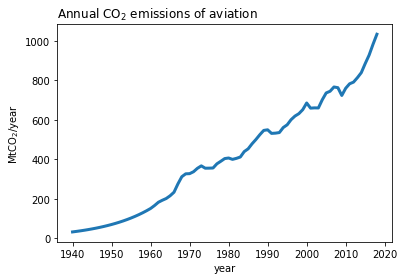

In [11]:
co2_1940 = np.zeros(2018-1940+1)
co2_1940[40:] = co2    # set the 1980 to 2018 values
    
DF_CO2_1940 = pd.read_csv(path+"data/co2_1940.csv")
co2_1940[:40] = DF_CO2_1940["CO2 [Tg/yr]"]

plt.plot(np.arange(1940,2019),co2_1940,lw=3)
plt.title(r"Annual CO$_2$ emissions of aviation",loc="left")
plt.ylabel(r"MtCO$_2$/year")
plt.xlabel("year");

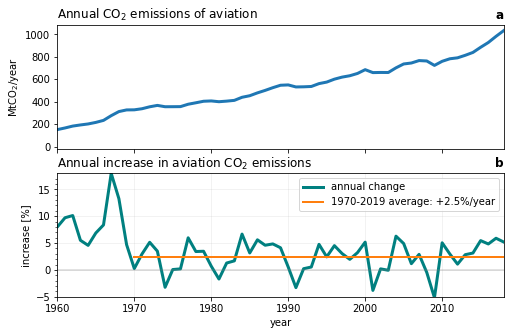

In [12]:
annual_incr = co2_1940[1:]/co2_1940[:-1]
start19XX = 1970-1940
annual_incr_mean = 100*(np.mean(co2_1940[start19XX+1:]/co2_1940[start19XX:-1]) - 1)

fig,(ax0,ax) = plt.subplots(2,1,figsize=(8,5),sharex=True)

ax0.plot(np.arange(1940,2019),co2_1940,lw=3)
ax.plot(np.arange(1941,2019),(annual_incr-1)*100,"teal",lw=3,label="annual change")
ax.axhline(0,color="grey",alpha=0.3)
ax.plot([1970,2019],np.ones(2)*annual_incr_mean,lw=2,color="C1",label="1970-2019 average: +{:.1f}%/year".format(annual_incr_mean))

ax.set_title(r"Annual increase in aviation CO$_2$ emissions",loc="left")
ax0.set_title(r"Annual CO$_2$ emissions of aviation",loc="left")
ax.set_title("b",loc="right",fontweight="bold")
ax0.set_title("a",loc="right",fontweight="bold")
ax.set_xlim(1960,2018)
ax.set_ylim(-5,18)
ax.set_xlabel("year")
ax.set_ylabel("increase [%]")
ax0.set_ylabel("MtCO$_2$/year")
ax.set_yticks(np.arange(-5,18),minor=True);
ax.grid(alpha=0.2)
ax.legend(loc=1)

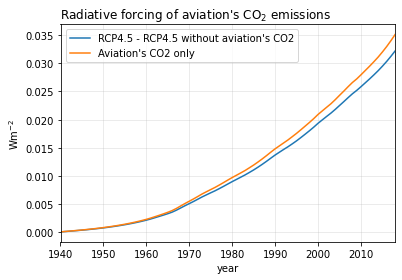

In [13]:
# RUN FAIR
rcp_years = rcp26.Emissions.year
co2_1765 = np.zeros(len(rcp_years))
co2_1765[(rcp_years > 1939)*(rcp_years < 2019)] = co2_1940/1000*(12/44)

# control simulations: RCP4.5 as baseline (doesn't change with RCP2.6,6.0 as only 1940-2018 is considered here)
emissions26 = rcp26.Emissions.emissions.copy()
emissions45 = rcp45.Emissions.emissions.copy()
emissions60 = rcp60.Emissions.emissions.copy()

C26,F26,T26 = fair_scm(emissions=emissions26)
C45,F45,T45 = fair_scm(emissions=emissions45)
C60,F60,T60 = fair_scm(emissions=emissions60)

# create NO-AVIATION scenarios from RCP scenarios
emissions45[:,1] -= co2_1765

t1940 = int(1940-rcp_years[0])
t1980 = int(1980-rcp_years[0])
t2018 = int(2019-rcp_years[0])
t2050 = int(2050-rcp_years[0])
C45noav, F45noav, T45noav= fair_scm(emissions=emissions45)

# only aviation emissions
Cav_only, Fav_only, Tav_only = fair_scm(emissions=co2_1765,useMultigas=False)

plt.plot(rcp_years[t1940:t2018],(F45-F45noav)[t1940:t2018,0],label="RCP4.5 - RCP4.5 without aviation's CO2")
plt.plot(rcp_years[t1940:t2018],Fav_only[t1940:t2018],label="Aviation's CO2 only")

plt.title(r"Radiative forcing of aviation's CO$_2$ emissions",loc="left")
plt.legend()
plt.xlim(1940,2018)
plt.grid(alpha=0.3)
plt.xlabel("year")
plt.ylabel(r"Wm$^{-2}$");

In [14]:
t1980 = int(1980-rcp_years[0])

# multi scenario mean [mW/m^2]
co2rf_1940 = (F45-F45noav)[t1940:t2018,0]*1000
co2rf_1980 = (F45-F45noav)[t1980:t2018,0]*1000
co2ppm_1940 = (C45-C45noav)[t1940:t2018,0]
years_1940 = rcp_years[t1940:t2018]

DF = pd.DataFrame(np.vstack((years_1940,co2ppm_1940,co2rf_1940)).T,columns=["year","CO2 ppm","CO2 RF [mW/m^2]"])
DF['year'] = DF['year'].astype(int)
# DF.to_csv("../data/CO2_radiative_forcing_FAIR.csv",float_format = "%.4f")

In [15]:
co2rf_1940

array([ 0.07179661,  0.13347958,  0.19332939,  0.25438809,  0.31797716,
        0.38498608,  0.45581658,  0.53096618,  0.61106459,  0.69675598,
        0.78816259,  0.88566714,  0.99010709,  1.1021017 ,  1.2222412 ,
        1.35098576,  1.48931361,  1.63840133,  1.79923082,  1.97282657,
        2.15961407,  2.36626197,  2.59482577,  2.82840683,  3.06131139,
        3.30940924,  3.58188662,  3.92913003,  4.32587751,  4.72256951,
        5.09767286,  5.4794978 ,  5.88156142,  6.28772043,  6.65551347,
        7.0181191 ,  7.3706973 ,  7.76174603,  8.16744995,  8.58661648,
        9.00133142,  9.39413761,  9.79059301, 10.19009314, 10.62688882,
       11.07489535, 11.55966029, 12.06985343, 12.60775846, 13.16942863,
       13.72009515, 14.22135067, 14.71637081, 15.19074021, 15.70624576,
       16.24261989, 16.82124436, 17.42150576, 18.03256548, 18.67033271,
       19.35299893, 19.96527417, 20.57071542, 21.16190404, 21.81405302,
       22.50828081, 23.19684228, 23.90560349, 24.58812123, 25.18

## 4.2 Effective radiative forcings of O3, CH4, SWV, netNOX, BC, SO4, H20, contrails

In [16]:
o3short_rf = nox*ERF["O3short"]
ch4_rf = nox*ERF["CH4"]
o3long_rf = nox*ERF["O3long"]
swv_rf = nox*ERF["SWV"]
bc_rf = bc*ERF["BC"]
so4_rf = so2*ERF["SO4"]     # SO2 vs SO4, correct?
h2o_rf = h2o*ERF["H2O"]
contrail_rf = scaled_distance*ERF["contrail"]

## 5. Sum non-CO2 radiative forcings

In [17]:
nonCO2_rf = o3short_rf + ch4_rf + o3long_rf + swv_rf + bc_rf + so4_rf + h2o_rf + contrail_rf

In [18]:
def extrapolate_back_exp(xend,N,p):
    x = np.zeros(N)    # preallocate array
    x[-1] = xend       # initial (i.e. end) condition
    for i in range(1,N):
        x[N-i-1] = x[N-i]*(1-p/100)
    return x

In [19]:
# Extrapolate the non-CO2 radiative from 1980 back to 1940 at 3% annual increase
nonCO2_rf1940 = np.zeros(2019-1940)
nonCO2_rf1940[1980-1940:] = nonCO2_rf         # copy 1980-2019
p = 3                                         # annual increase in [%]
nonCO2_rf1940[:41] = extrapolate_back_exp(nonCO2_rf[0],1980-1939,p)

## 6. Plot individual ERFs for aviation

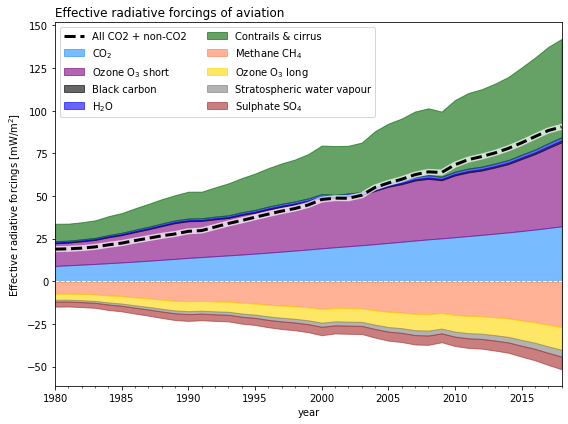

In [20]:
years = fuel_usage["year"]

fig,ax1 = plt.subplots(1,1,figsize=(8,6),sharex=True)

alfa=0.6
# pack all radiative forcings in one array
all_positive_rfs = np.array([np.zeros_like(years),
                             co2rf_1980,
                             o3short_rf,
                             bc_rf,
                             h2o_rf,
                             contrail_rf])

all_negative_rfs = np.array([np.zeros_like(years),
                             ch4_rf,
                             o3long_rf,
                             swv_rf,
                             so4_rf])

rf_posnames = [r"CO$_2$",r"Ozone O$_3$ short","Black carbon",r"H$_2$O","Contrails & cirrus"]
rf_negnames = [r"Methane CH$_4$",r"Ozone O$_3$ long","Stratospheric water vapour",r"Sulphate SO$_4$"]
poscolours = ["","dodgerblue","purple","k","blue","darkgreen","red"]
negcolours = ["","coral","gold","grey","brown"]
for i in range(1,all_positive_rfs.shape[0]):
    ax1.fill_between(years,
                     np.sum(all_positive_rfs[:i+1,:],axis=0),
                     np.sum(all_positive_rfs[:i,:],axis=0),
                     alpha=alfa,label=rf_posnames[i-1],
                     edgecolor="white",color=poscolours[i])
    
for i in range(1,all_negative_rfs.shape[0]):
    ax1.fill_between(years,
                     np.sum(all_negative_rfs[:i+1,:],axis=0),
                     np.sum(all_negative_rfs[:i,:],axis=0),
                     alpha=alfa,label=rf_negnames[i-1],
                     edgecolor="white",color=negcolours[i])

ax1.plot(years,np.sum(all_negative_rfs,axis=0)+np.sum(all_positive_rfs,axis=0),"w",lw=6,alpha=0.7)
ax1.plot(years,np.sum(all_negative_rfs,axis=0)+np.sum(all_positive_rfs,axis=0),"k--",lw=3,label="All CO2 + non-CO2")
ax1.plot(years,np.zeros_like(years),"w--",lw=1)
    
ax1.set_title("Effective radiative forcings of aviation",loc="left")
ax1.legend(loc=2,ncol=2)

ax1.set_ylabel(r"Effective radiative forcings [mW/m$^2$]")
ax1.set_xlabel("year")

ax1.set_xlim(1980,2018)
# ax1.set_ylim(0,ax1.get_ylim()[1])
ax1.set_xticks(years,minor=True)
plt.tight_layout()
# plt.savefig("radiative_forcings_nonCO2.png",dpi=200)

# CAEP scenarios

In [21]:
# load ICAO's CAEP scnearios, column J is the moderate tech improvement scenario
caep11 = pd.read_csv(path+"data/CAEP11_trends.csv")
caep_years = np.array(caep11.iloc[4:,0])
caep_moderate = np.array(caep11.iloc[4:,ABC2index("J")],dtype=float)

In [22]:
caep_growth = caep_moderate[1:]/caep_moderate[:-1]
caep_growth

array([1.02761628, 1.02687412, 1.0261708 , 1.02684564, 1.02614379,
       1.02675159, 1.02729529, 1.02657005, 1.02705882, 1.02749141,
       1.02675585, 1.02714441, 1.02642706, 1.02780639, 1.02705411,
       1.03512195, 1.03487276, 1.03551913, 1.0351803 , 1.03568394,
       1.03527482, 1.03486529, 1.03522205, 1.03550296, 1.035     ,
       1.02829538, 1.02885906, 1.02804958, 1.02791878, 1.02839506,
       1.02821128, 1.02860479, 1.02837684, 1.0281457 , 1.02844874,
       1.02974948, 1.03041054, 1.03000492, 1.03056351, 1.03012048])

In [23]:
caep_year2018 = np.where(caep_years[1:] == 2018)[0][0]

## 8. COVID-motivated emission scenarios

In [24]:
# load opensky flight data
opensky_file = pd.read_csv(path+"data/Opensky_EURO_2019_2020.csv")
dates_os = opensky_file["Date"]
nflights_global = opensky_file["N_Flights_OS"].to_numpy()
nflights_europe = opensky_file["N_Flights_EURO"].to_numpy()

In [25]:
import datetime
dates = [0,]*len(dates_os)

for i in range(len(dates_os)):
    day,month,year = dates_os[i].split("/")
    dates[i] = datetime.date(int(year),int(month),int(day))
    
dayssince2019 = np.array([(d-datetime.date(2019,1,1)).days for d in dates])

daystill2030 = np.arange(15*365)
datestill2030 = [datetime.date(2019,1,1)+datetime.timedelta(int(d)) for d in daystill2030]

# indices in dates lists that correspond to the respective dates
march1 = [i for i in range(len(datestill2030)) if datestill2030[i] == datetime.date(2020,3,1)][0]
jan1 = [i for i in range(len(datestill2030)) if datestill2030[i] == datetime.date(2020,1,1)][0]
jan1_2021 = [i for i in range(len(datestill2030)) if datestill2030[i] == datetime.date(2021,1,1)][0]
jan1_2024 = [i for i in range(len(datestill2030)) if datestill2030[i] == datetime.date(2024,1,1)][0]

# 3% annual increase model
def peval(x, p):
    return p[0] * 1.03**np.ceil(x/365.25)

def residuals(p,y,x):
    return y - peval(x,p)

# least square fitting of the 3% increase model
p0 = [0]
plsq2019 = leastsq(residuals, p0, args=(nflights_global[:march1], dayssince2019[:march1]))

covid_drop = 45
plsq2020 = np.mean(nflights_global[:march1])*(100-covid_drop)/100

# no covid scenario
nflights_nocovid = peval(daystill2030,plsq2019[0])

# scenarios covid + recovery until 2025 + incline/const/decline after 2025
nflights_recovery = plsq2020*np.ones_like(daystill2030)
nflights_recovery_const = plsq2020*np.ones_like(daystill2030)
nflights_recovery_decline = plsq2020*np.ones_like(daystill2030)

# set 2019 data to 3% incline for all these scenarios
nflights_recovery[daystill2030 < 365] = nflights_nocovid[daystill2030 < 365]
nflights_recovery_const[daystill2030 < 365] = nflights_nocovid[daystill2030 < 365]
nflights_recovery_decline[daystill2030 < 365] = nflights_nocovid[daystill2030 < 365]

# what to do in the recovery period 2021-2025
p_rec1 = 16
p_rec2 = 13
p_rec3 = 10

j = 1
for i in range(jan1_2021,jan1_2024):
    nflights_recovery[i] = nflights_recovery[jan1_2021-1]*(1+p_rec1/100)**np.ceil(j/365.25)
    nflights_recovery_const[i] = nflights_recovery[jan1_2021-1]*(1+p_rec2/100)**np.ceil(j/365.25)
    nflights_recovery_decline[i] = nflights_recovery[jan1_2021-1]*(1+p_rec3/100)**np.ceil(j/365.25)
    j += 1
    
# what to do until 2030
p_after1 = 3
p_after2 = 0
p_after3 = -2.5

j = 1
for i in range(jan1_2024,len(datestill2030)):
    nflights_recovery[i] = nflights_recovery[jan1_2024-1]*(1+p_after1/100)**np.ceil(j/365.25)
    nflights_recovery_const[i] = nflights_recovery_const[jan1_2024-1]*(1+p_after2/100)**np.ceil(j/365.25)
    nflights_recovery_decline[i] = nflights_recovery_decline[jan1_2024-1]*(1+p_after3/100)**np.ceil(j/365.25)
    j+=1


In [26]:
# CO2 emissions for scenarios
years_future = np.arange(2018,2051)
years1940 = np.arange(1940,2051)
year2018 = 2018-1940
co2_scenario1 = np.zeros(len(years1940))     # decline scenario
co2_scenario2 = np.zeros(len(years1940))     # const scenario
co2_scenario3 = np.zeros(len(years1940))     # incline scenario
co2_scenario4 = np.zeros(len(years1940))     # nocovid scenario

# copy over 1940-2018 data
co2_scenario1[years1940 <= 2018] = co2_1940  # units [MtCO2/year]
co2_scenario2[years1940 <= 2018] = co2_1940
co2_scenario3[years1940 <= 2018] = co2_1940
co2_scenario4[years1940 <= 2018] = co2_1940

# always 3% increase for nocovid scenario
# for i in range(1,len(years_future)): 
#     co2_scenario4[year2018+i] = co2_scenario4[year2018+i-1]*(1+p_after1/100)

# take ICAO's CAEP moderate tech improvement scenario for No Pandemic (scenario4 here)
for i in range(1,len(years_future)):
    co2_scenario4[year2018+i] = co2_scenario4[year2018+i-1]*caep_growth[caep_year2018+i]

# 3% increase in 2019 for all
co2_scenario1[year2018+1] = co2_scenario1[year2018]*(1+p_after1/100)
co2_scenario2[year2018+1] = co2_scenario2[year2018]*(1+p_after1/100)
co2_scenario3[year2018+1] = co2_scenario3[year2018]*(1+p_after1/100)

# 45% drop in 2020 for all but no-covid scenario
covid_drop = 45
co2_scenario1[year2018+2] = co2_scenario1[year2018+1]*(1-covid_drop/100)
co2_scenario2[year2018+2] = co2_scenario2[year2018+1]*(1-covid_drop/100)
co2_scenario3[year2018+2] = co2_scenario3[year2018+1]*(1-covid_drop/100)

# recovery period
for i in range(3,7):   # 2021,2022,2023,2024
    co2_scenario1[year2018+i] = co2_scenario1[year2018+i-1]*(1+p_rec3/100)
    co2_scenario2[year2018+i] = co2_scenario2[year2018+i-1]*(1+p_rec2/100)
    co2_scenario3[year2018+i] = co2_scenario3[year2018+i-1]*(1+p_rec1/100)
    
# after that till 2050 period
for i in range(7,len(years_future)):   # 2021,2022,2023
    co2_scenario1[year2018+i] = co2_scenario1[year2018+i-1]*(1+p_after3/100)
    co2_scenario2[year2018+i] = co2_scenario2[year2018+i-1]*(1+p_after2/100)
    co2_scenario3[year2018+i] = co2_scenario3[year2018+i-1]*(1+p_after1/100)

## 9. Non-CO2 radiative forcing: Aviation's contribution to global warming

In [27]:
# projections into the future
years_future = np.arange(2018,2051)
years1940 = np.arange(1940,2051)
year2018 = 2018-1940
nonco2rf_scenario1 = np.zeros(len(years1940))     # Scneario: Long-Term Decline
nonco2rf_scenario2 = np.zeros(len(years1940))     # Scenario: Zero Long-Term Growth
nonco2rf_scenario3 = np.zeros(len(years1940))     # Scenario: Back
nonco2rf_scenario4 = np.zeros(len(years1940))     # Scenario: No COVID

# copy over 1940-2018 data
nonco2rf_scenario1[years1940 <= 2018] = nonCO2_rf1940
nonco2rf_scenario2[years1940 <= 2018] = nonCO2_rf1940
nonco2rf_scenario3[years1940 <= 2018] = nonCO2_rf1940
nonco2rf_scenario4[years1940 <= 2018] = nonCO2_rf1940

# for 2019 set all scenarios to 3% incline scenario
percent_incline = 3
for scenario in [nonco2rf_scenario1,nonco2rf_scenario2,nonco2rf_scenario3]:
    scenario[year2018+1] = scenario[year2018+0]*(1+percent_incline/100)
    
# 3% continous incline for non covid scenario till 2050
# for i in range(1,len(years_future)):
#     nonco2rf_scenario4[year2018+i] = nonco2rf_scenario4[year2018+i-1]*(1+percent_incline/100)

# take ICAO's CAEP moderate tech improvement scenario for No Pandemic (scenario4 here)
for i in range(1,len(years_future)):
    nonco2rf_scenario4[year2018+i] = nonco2rf_scenario4[year2018+i-1]*caep_growth[caep_year2018+i]

# 45% drop in 2020 for all but no-covid scenario
covid_drop = 45
for scenario in [nonco2rf_scenario1,nonco2rf_scenario2,nonco2rf_scenario3]:
    scenario[year2018+2] = scenario[year2018+1]*(1-covid_drop/100)

# recovery period
for i in range(3,7):   # 2021,2022,2023,2024
    nonco2rf_scenario1[year2018+i] = nonco2rf_scenario1[year2018+i-1]*(1+p_rec3/100)
    nonco2rf_scenario2[year2018+i] = nonco2rf_scenario2[year2018+i-1]*(1+p_rec2/100)
    nonco2rf_scenario3[year2018+i] = nonco2rf_scenario3[year2018+i-1]*(1+p_rec1/100)
    
    
# after that till 2050 period
for i in range(7,len(years_future)):   # 2021,2022,2023,2024
    nonco2rf_scenario1[year2018+i] = nonco2rf_scenario1[year2018+i-1]*(1+p_after3/100)
    nonco2rf_scenario2[year2018+i] = nonco2rf_scenario2[year2018+i-1]*(1+p_after2/100)
    nonco2rf_scenario3[year2018+i] = nonco2rf_scenario3[year2018+i-1]*(1+p_after1/100)
    

In [28]:
# DEFINE THE LINEAR OPERATOR CONVERTING CUMULATIVE CO2 EMISSIONS TO RADIATIVE FORCING
# USE ITS INVERSE TO CONVERT NON-CO2 RADIATIVE FORCING TO WARMING-EQUIVALENT EMISSIONS

def EFmod(nyr,a):              # number of years nyr, entries a of Toeplitz matrix
    Fcal = np.zeros((nyr,nyr)) # create linear operator to convert emissions to forcing
    time = np.arange(nyr+1)    # extend time array to compute derivatives
    F_0 = a[4]*a[13]*a[0]*time # compute constant term (if there is one, otherwise a[0]=0)
    for j in [1,2,3]:          # loop over gas decay terms to calculate AGWP using AR5 formula
        F_0=F_0+a[j]*a[4]*a[13]*a[j+5]*(1-np.exp(-time/a[j+5]))
    for i in range(0,nyr):     # first-difference AGWP to obtain AGFP
        Fcal[i,0]=F_0[i+1]-F_0[i]
    for j in range(1,nyr):     # build up the rest of the Toeplitz matrix
        Fcal[j:nyr,j]=Fcal[0:nyr-j,0]
    return Fcal

m_atm = 5.1352e18 # AR5 official mass of atmosphere in kg
m_air = 28.97e-3  # AR5 official molar mass of air
m_car = 12.01e-3  # AR5 official molar mass of carbon
m_co2 = 44.01e-3  # AR5 official molar mass of CO2
m_ch4 = 16.043e-3 # AR5 official molar mass of CH4

# Set to AR5 Values for CO2
a_ar5 = np.zeros(20)
a_ar5[0:4] = [0.21787,0.22896,0.28454,0.26863]
a_ar5[4] = 1e12*1e6/m_co2/(m_atm/m_air)# old value = 0.471 ppm/GtC # convert GtCO2 to ppm
a_ar5[5:9] = [1e8,381.330,34.7850,4.12370]
a_ar5[10:12] = [0.631*0.7,0.429*0.7] #AR5 sensitivity coeffs multiplied by 0.7
a_ar5[13] = 1.37e-2 # rad efficiency in W/m2/ppm
a_ar5[14] = 0
a_ar5[15:17] = [8.400,409.5]
a_ar5[18:21] = 0

# get the linear operator, which takes W/m^2 and returns GtCO2
nyears = len(years1940)
FCO2 = EFmod(nyears,a_ar5)

In [29]:
# APPLY THE INVERSE OF THE LINEAR OPERATOR
# cumsum(Linv(forcing)) = Linv(cumsum(forcing)) as both operations are linear
nonCO2_cumemissions1 = np.linalg.solve(FCO2,np.cumsum(nonco2rf_scenario1/1000))  # convert mW/m^2 to W/m^2 here
nonCO2_cumemissions2 = np.linalg.solve(FCO2,np.cumsum(nonco2rf_scenario2/1000))
nonCO2_cumemissions3 = np.linalg.solve(FCO2,np.cumsum(nonco2rf_scenario3/1000))
nonCO2_cumemissions4 = np.linalg.solve(FCO2,np.cumsum(nonco2rf_scenario4/1000))

# equivalent warming CO2+NON-CO2
TCRE = 0.00045    # Transient climate response to cumulative carbon emissions [K/GtCO2]
warming_scenario1 = TCRE*(nonCO2_cumemissions1+np.cumsum(co2_scenario1)/1000)    # convert from MtCO2 to GtCO2 here
warming_scenario2 = TCRE*(nonCO2_cumemissions2+np.cumsum(co2_scenario2)/1000)
warming_scenario3 = TCRE*(nonCO2_cumemissions3+np.cumsum(co2_scenario3)/1000)
warming_scenario4 = TCRE*(nonCO2_cumemissions4+np.cumsum(co2_scenario4)/1000)

# CO2 only warming
co2warm_scenario1 = TCRE*np.cumsum(co2_scenario1)/1000    # [˚C] = [˚C/GtCO2]*[MtCO2]/1000
co2warm_scenario2 = TCRE*np.cumsum(co2_scenario2)/1000
co2warm_scenario3 = TCRE*np.cumsum(co2_scenario3)/1000
co2warm_scenario4 = TCRE*np.cumsum(co2_scenario4)/1000

In [30]:
# Warming in 2019
T = warming_scenario3[year2018+1]
ΔT0 = T*(55/100.9)
ΔT1 = T*(145/100.9)
"Warming in 2019: {:.3f}˚C ({:.3f}-{:.3f}˚C)".format(T,ΔT0,ΔT1)

'Warming in 2019: 0.039˚C (0.021-0.056˚C)'

In [31]:
# Warming in 2050
T = warming_scenario3[-1]
ΔT0 = T*(55/100.9)
ΔT1 = T*(145/100.9)
"Warming in 2050: {:.3f}˚C ({:.3f}-{:.3f}˚C)".format(T,ΔT0,ΔT1)

'Warming in 2050: 0.090˚C (0.049-0.130˚C)'

In [32]:
(warming_scenario3[-1] - warming_scenario3[year2018+1])/warming_scenario3[-1]

0.5665218444459982

## 10. Main figure

Text(2050.5, 443.9002948252917, 'Long-Term Decline\n-2.5%/year after 2024')

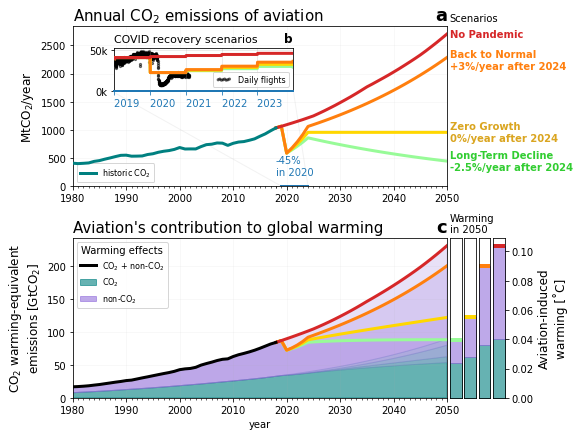

In [33]:
fig = plt.figure(figsize=(8,6))

ax1 = fig.add_axes([0.11,0.57,0.65,0.37])
ax3 = fig.add_axes([0.11,0.08,0.65,0.37])

# covid response inlay axis
ax = fig.add_axes([0.1825,0.79,0.31,0.1])

# scenario axes
pos = ax3.get_position()
ax_s1 = fig.add_axes([pos.x1+0.005,pos.y0,0.02,pos.y1-pos.y0])
ax_s2 = fig.add_axes([pos.x1+0.03,pos.y0,0.02,pos.y1-pos.y0])
ax_s3 = fig.add_axes([pos.x1+0.055,pos.y0,0.02,pos.y1-pos.y0])
ax_s4 = fig.add_axes([pos.x1+0.08,pos.y0,0.02,pos.y1-pos.y0])
ax_s4.yaxis.set_label_position("right")
ax_s4.yaxis.tick_right()

ax.plot(datestill2030,nflights_nocovid/1000,"C3",lw=3,zorder=10)
ax.plot(datestill2030,nflights_recovery/1000,"C1",lw=3,zorder=9)
ax.plot(datestill2030,nflights_recovery_const/1000,"gold",lw=3,zorder=8)
ax.plot(datestill2030,nflights_recovery_decline/1000,"palegreen",lw=3,zorder=7)
ax.grid(alpha=.3)

ax.scatter(dates,nflights_global/1000,5,color="k",alpha=0.5,label="Daily flights",zorder=-1)

ax.yaxis.set_major_formatter(FormatStrFormatter('%d'+'k'))
# ax.set_ylabel("Daily flights")
ax.set_xlim(datetime.date(2019,1,1),datetime.date(2023,12,31))
ax.set_ylim(0,53)
ax.legend(loc=4,scatterpoints=8,fontsize=8)
ax.set_title("COVID recovery scenarios",loc="left",fontsize=11)
ax.set_title("b",loc="right",fontweight="bold")

ax.xaxis.set_major_locator(YearLocator(1))
ax.xaxis.set_major_formatter(DateFormatter("        %Y"))
ax.spines['bottom'].set_color("C0")
ax.spines['bottom'].set_linewidth(2)
ax.tick_params(axis='x', colors="C0")

# lines for orientation
ax1.plot([2024,2021.3],[0,1660],"grey",lw=1,alpha=0.1)
ax1.plot([2019,1987.8],[0,1660],"grey",lw=1,alpha=0.1)
ax1.plot([2019,2024],[10,10],"C0",lw=2)
# ax1.arrow(2020.2,co2_scenario4[years_future==2020][0],
#           0,0.7*(co2_scenario1[years_future==2020]-co2_scenario4[years_future==2020])[0],
#           width=0.1,zorder=12,color="C0",head_width=0.6,head_length=100)
ax1.text(2018,200,"-45%\nin 2020",color="C0")

# historic
ax1.plot(years_1940,co2_1940,"teal",lw=3,label=r"historic CO$_2$",zorder=12)

# future scenarios
from2018 = 2018-1940
ax1.plot(years1940[from2018:],co2_scenario4[from2018:],"C3",lw=3,zorder=11)
ax1.plot(years1940[from2018:],co2_scenario3[from2018:],"C1",lw=3,zorder=10)
ax1.plot(years1940[from2018:],co2_scenario2[from2018:],"gold",lw=3,zorder=9)
ax1.plot(years1940[from2018:],co2_scenario1[from2018:],"palegreen",lw=3,zorder=8)

ax1.set_title(r"Annual CO$_2$ emissions of aviation",loc="left",fontsize=15)
ax1.set_title("a",loc="right",fontweight="bold",fontsize=18)
ax3.set_title("c",loc="right",fontweight="bold",fontsize=18)

ax1.set_ylabel(r"MtCO$_2$/year",fontsize=12)
ax1.set_xlim(1980,2050)
ax3.set_xlim(1980,2050)
ax1.set_ylim(0,ax1.get_ylim()[1])

ax1.set_xticks(np.hstack((years,years_future)),minor=True)
ax3.set_xticks(np.hstack((years,years_future)),minor=True)

# FORCING-EQUIVALENT EMISSIONS
# historic
alfa=0.6
h4 = lambda y: 1-np.sqrt(np.sqrt(1-y))  # four-level superimposed alpha

# cumulative
till2018 = 2019-1940
ax3.plot(years1940[:till2018],warming_scenario1[:till2018]/TCRE,"k",lw=3,label=r"CO$_2$ + non-CO$_2$",zorder=12)

# cumulative future
# CO2
ax3.fill_between(years1940,np.cumsum(co2_scenario1)/1000,
                 alpha=h4(alfa),color="teal")
ax3.fill_between(years1940,np.cumsum(co2_scenario2)/1000,
                 alpha=h4(alfa),color="teal")
ax3.fill_between(years1940,np.cumsum(co2_scenario3)/1000,
                 alpha=h4(alfa),color="teal")
ax3.fill_between(years1940,np.cumsum(co2_scenario4)/1000,
                 alpha=h4(alfa),color="teal")
ax3.fill_between([0,1],[0,1],alpha=alfa,color="teal",label=r"CO$_2$") # for legend only

# NON-CO2
ax3.plot(years1940[from2018:],warming_scenario4[from2018:]/TCRE,
         "C3",lw=3,zorder=11)
ax3.plot(years1940[from2018:],warming_scenario3[from2018:]/TCRE,
         "C1",lw=3,zorder=10)
ax3.plot(years1940[from2018:],warming_scenario2[from2018:]/TCRE,
         "gold",lw=3,zorder=9)
ax3.plot(years1940[from2018:],warming_scenario1[from2018:]/TCRE,
         "palegreen",lw=3,zorder=8)

ax3.fill_between(years1940,warming_scenario1/TCRE,np.cumsum(co2_scenario1)/1000,
                 alpha=h4(alfa),color="mediumpurple")
ax3.fill_between(years1940,warming_scenario2/TCRE,np.cumsum(co2_scenario2)/1000,
                 alpha=h4(alfa),color="mediumpurple")
ax3.fill_between(years1940,warming_scenario3/TCRE,np.cumsum(co2_scenario3)/1000,
                 alpha=h4(alfa),color="mediumpurple")
ax3.fill_between(years1940,warming_scenario4/TCRE,np.cumsum(co2_scenario4)/1000,
                 alpha=h4(alfa),color="mediumpurple")
ax3.fill_between([0,1],[0,1],alpha=alfa,color="mediumpurple",label=r"non-CO$_2$") # for legend only

# SCENARIO COMPARISON 2050
ax_s1.axhline(warming_scenario1[-1],color="palegreen",lw=4)
ax_s2.axhline(warming_scenario2[-1],color="gold",lw=4)
ax_s3.axhline(warming_scenario3[-1],color="C1",lw=4)
ax_s4.axhline(warming_scenario4[-1],color="C3",lw=4)

ax_s1.fill_between([0,1],np.ones(2)*co2warm_scenario1[-1],color="teal",alpha=alfa)
ax_s2.fill_between([0,1],np.ones(2)*co2warm_scenario2[-1],color="teal",alpha=alfa)
ax_s3.fill_between([0,1],np.ones(2)*co2warm_scenario3[-1],color="teal",alpha=alfa)
ax_s4.fill_between([0,1],np.ones(2)*co2warm_scenario4[-1],color="teal",alpha=alfa)

ax_s1.fill_between([0,1],np.ones(2)*warming_scenario1[-1],np.ones(2)*co2warm_scenario1[-1],color="mediumpurple",alpha=alfa)
ax_s2.fill_between([0,1],np.ones(2)*warming_scenario2[-1],np.ones(2)*co2warm_scenario2[-1],color="mediumpurple",alpha=alfa)
ax_s3.fill_between([0,1],np.ones(2)*warming_scenario3[-1],np.ones(2)*co2warm_scenario3[-1],color="mediumpurple",alpha=alfa)
ax_s4.fill_between([0,1],np.ones(2)*warming_scenario4[-1],np.ones(2)*co2warm_scenario4[-1],color="mediumpurple",alpha=alfa)

ax3.set_title(r"Aviation's contribution to global warming",loc="left",fontsize=15)

ax3.set_ylabel(r"CO$_2$ warming-equivalent"+"\n"+"emissions [GtCO$_2$]",fontsize=12)
ax_s4.set_ylabel("Aviation-induced\nwarming [˚C]",fontsize=12)
ax3.set_xlabel("year",fontsize=10)
ax1.legend(loc=3,fontsize=8)
ax3.legend(loc=2,title="Warming effects",fontsize=8)

ax3.set_ylim(0,ax3.get_ylim()[1])
for ax in [ax_s1,ax_s2,ax_s3,ax_s4]:
    ax.set_ylim(0,TCRE*ax3.get_ylim()[1])
    ax.set_xlim(0,1)

for ax in [ax_s1,ax_s2,ax_s3]:
    ax.set_yticks([])
    ax.set_xticks([])

ax_s4.set_xticks([])

ax1.grid(alpha=0.1)
ax3.grid(alpha=0.1)
ax1.text(2050.5,ax1.get_ylim()[1]*1.03,"Scenarios")
ax3.text(2050.5,ax3.get_ylim()[1]*1.035,"Warming\nin 2050")
ax1.text(2050.5,co2_scenario4[-1],"No Pandemic",color="C3",fontweight="bold",va="center")
ax1.text(2050.5,co2_scenario3[-1]*0.98,"Back to Normal\n+3%/year after 2024",color="C1",fontweight="bold",va="center")
ax1.text(2050.5,co2_scenario2[-1],"Zero Growth\n0%/year after 2024",color="goldenrod",fontweight="bold",va="center")
ax1.text(2050.5,co2_scenario1[-1],"Long-Term Decline\n-2.5%/year after 2024",color="limegreen",fontweight="bold",va="center")

# plt.savefig("../plots/emissions_warming.pdf")
# plt.savefig("../plots/emissions_warming.png",dpi=200)

In [34]:
# aviation-induced warming 1990-2019 (i.e. pre COVID)
av_warming2019 = (warming_scenario3[years1940 == 2019]-warming_scenario3[years1940 == 1990])[0]
av_warming2019    # in ˚C

0.027345724675656196

In [35]:
# warming contribution of aviation since 1990 from HadCRUT5
warming_in_2019 = 1.17
warming_in_1990 = 0.65
(av_warming2019)/(warming_in_2019-warming_in_1990)*100   # in %

5.258793206856962

In [36]:
# are temperatures stable?
warming_scenario1[-25:]

array([0.03834624, 0.03852666, 0.03868453, 0.03882289, 0.0389443 ,
       0.03905092, 0.03914459, 0.03922687, 0.03929906, 0.0393623 ,
       0.03941753, 0.03946559, 0.03950717, 0.03954289, 0.03957327,
       0.03959877, 0.03961979, 0.03963667, 0.03964974, 0.03965926,
       0.03966547, 0.0396686 , 0.03966884, 0.03966638, 0.03966137])

In [37]:
# reaching pre-covid in 2024?
co2_scenario3[from2018:]

array([1033.70060505, 1064.7116232 ,  585.59139276,  679.2860156 ,
        787.9717781 ,  914.04726259, 1060.29482461, 1092.10366935,
       1124.86677943, 1158.61278281, 1193.3711663 , 1229.17230128,
       1266.04747032, 1304.02889443, 1343.14976127, 1383.4442541 ,
       1424.94758173, 1467.69600918, 1511.72688945, 1557.07869614,
       1603.79105702, 1651.90478873, 1701.46193239, 1752.50579037,
       1805.08096408, 1859.233393  , 1915.01039479, 1972.46070663,
       2031.63452783, 2092.58356367, 2155.36107058, 2220.02190269,
       2286.62255978])

In [38]:
# which level of pre-COVID is reached in scenario2?
co2_scenario2[from2018:]/co2_scenario2[years1940==2019]

array([0.97087379, 1.        , 0.55      , 0.6215    , 0.702295  ,
       0.79359335, 0.89676049, 0.89676049, 0.89676049, 0.89676049,
       0.89676049, 0.89676049, 0.89676049, 0.89676049, 0.89676049,
       0.89676049, 0.89676049, 0.89676049, 0.89676049, 0.89676049,
       0.89676049, 0.89676049, 0.89676049, 0.89676049, 0.89676049,
       0.89676049, 0.89676049, 0.89676049, 0.89676049, 0.89676049,
       0.89676049, 0.89676049, 0.89676049])

## 11. Supplementary figures
Run FAIR with scenario 1-4 to obtain CO2 forcings till 2050

In [39]:
rcp_years = rcp26.Emissions.year
co2_1765_scenario1 = np.zeros(len(rcp_years))
co2_1765_scenario2 = np.zeros(len(rcp_years))
co2_1765_scenario3 = np.zeros(len(rcp_years))
co2_1765_scenario4 = np.zeros(len(rcp_years))

# aviation emissions for various scenarios, convert from MtCO2 to GtC
mass_ratio = (12/44)    # 12g/mol for C, 44g/mol for CO2 (12+2*16)
co2_1765_scenario1[(rcp_years > 1939)*(rcp_years < 2051)] = co2_scenario1/1000*mass_ratio
co2_1765_scenario2[(rcp_years > 1939)*(rcp_years < 2051)] = co2_scenario2/1000*mass_ratio
co2_1765_scenario3[(rcp_years > 1939)*(rcp_years < 2051)] = co2_scenario3/1000*mass_ratio
co2_1765_scenario4[(rcp_years > 1939)*(rcp_years < 2051)] = co2_scenario4/1000*mass_ratio

t2018 = int(2018-rcp_years[0])
t2050 = int(2051-rcp_years[0])
co2rf_2050_all_scenarios = np.zeros((3,4,t2050-t2018))
temp_2050_all_scenarios = np.zeros((3,4,t2050-t2018))

for isc,scenario in enumerate([co2_1765_scenario1,\
                               co2_1765_scenario2,\
                               co2_1765_scenario3,\
                               co2_1765_scenario4]):
    
    # control simulations: RCP2.6 4.5, 6.0 as baseline
    emissions26 = rcp26.Emissions.emissions.copy()
    emissions45 = rcp45.Emissions.emissions.copy()
    emissions60 = rcp60.Emissions.emissions.copy()

    # create NO-AVIATION scenarios from RCP scenarios
    emissions26[:,1] -= scenario
    emissions45[:,1] -= scenario
    emissions60[:,1] -= scenario

    # RUN FAIR
    C26noav, F26noav, T26noav = fair_scm(emissions=emissions26)
    C45noav, F45noav, T45noav = fair_scm(emissions=emissions45)
    C60noav, F60noav, T60noav = fair_scm(emissions=emissions60)

    co2rf_2050_all_scenarios[0,isc,:] = (F26-F26noav)[t2018:t2050,0]
    co2rf_2050_all_scenarios[1,isc,:] = (F45-F45noav)[t2018:t2050,0]
    co2rf_2050_all_scenarios[2,isc,:] = (F60-F60noav)[t2018:t2050,0]
    
    temp_2050_all_scenarios[0,isc,:] = (T26-T26noav)[t2018:t2050]
    temp_2050_all_scenarios[1,isc,:] = (T45-T45noav)[t2018:t2050]
    temp_2050_all_scenarios[2,isc,:] = (T60-T60noav)[t2018:t2050]
    

In [40]:
# average RCP2.6,4.5 and 6.0
co2rf_2050_all_scenarios_m = co2rf_2050_all_scenarios.mean(axis=0)
temp_2050_all_scenarios_m = temp_2050_all_scenarios.mean(axis=0)

co2rf_scenario1 = 1000*co2rf_2050_all_scenarios_m[0,:]
co2rf_scenario2 = 1000*co2rf_2050_all_scenarios_m[1,:]
co2rf_scenario3 = 1000*co2rf_2050_all_scenarios_m[2,:]
co2rf_scenario4 = 1000*co2rf_2050_all_scenarios_m[3,:]

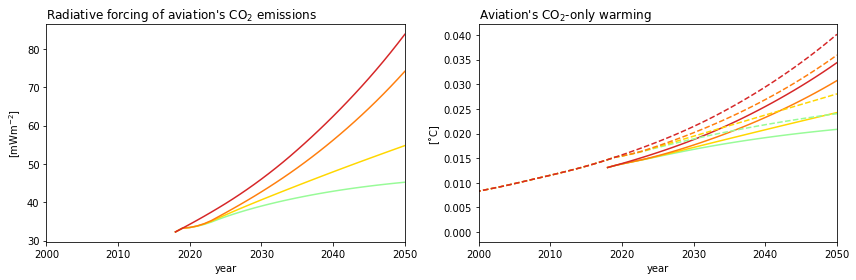

In [41]:
fig,(ax1,ax2) = plt.subplots(1,2,sharex=True,figsize=(12,4))

ax1.plot(years_future,co2rf_scenario1,"palegreen")
ax1.plot(years_future,co2rf_scenario2,"gold")
ax1.plot(years_future,co2rf_scenario3,"C1")
ax1.plot(years_future,co2rf_scenario4,"C3")

ax2.plot(years_future,temp_2050_all_scenarios_m[0,:],"palegreen")
ax2.plot(years_future,temp_2050_all_scenarios_m[1,:],"gold")
ax2.plot(years_future,temp_2050_all_scenarios_m[2,:],"C1")
ax2.plot(years_future,temp_2050_all_scenarios_m[3,:],"C3")

# TCRE-based as comparison
ax2.plot(years1940,co2warm_scenario1,"--",color="palegreen")
ax2.plot(years1940,co2warm_scenario2,"--",color="gold")
ax2.plot(years1940,co2warm_scenario3,"--",color="C1")
ax2.plot(years1940,co2warm_scenario4,"--",color="C3")

ax1.set_xlabel("year")
ax2.set_xlabel("year")
ax1.set_ylabel(r"[mWm$^{-2}$]")
ax2.set_ylabel("[˚C]")
ax1.set_title("Radiative forcing of aviation's CO$_2$ emissions",loc="left")
ax2.set_title("Aviation's CO$_2$-only warming",loc="left")
ax1.set_xlim(2000,2050)
plt.tight_layout()

In [42]:
cumco2 = np.sum(co2_1940)/1000    # convert to GtCO2
cumco2_scenario1 = np.cumsum(co2_scenario1)/1000
cumco2_scenario2 = np.cumsum(co2_scenario2)/1000
cumco2_scenario3 = np.cumsum(co2_scenario3)/1000
cumco2_scenario4 = np.cumsum(co2_scenario4)/1000

[]

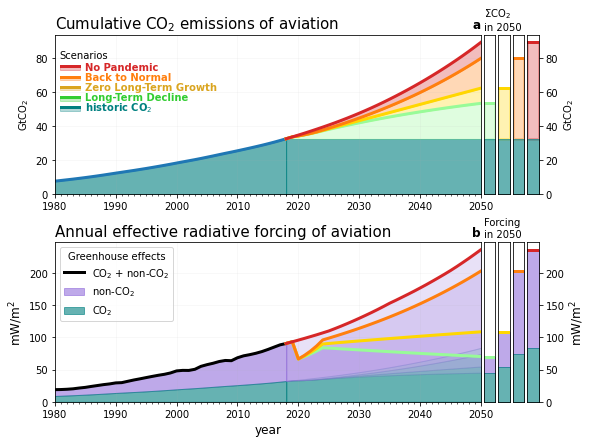

In [43]:
fig = plt.figure(figsize=(8,6))

ax1 = fig.add_axes([0.08,0.56,0.74,0.37])
ax2 = fig.add_axes([0.08,0.08,0.74,0.37])

# scenario axes
pos = ax1.get_position()
ax1_s1 = fig.add_axes([pos.x1+0.005,pos.y0,0.02,pos.y1-pos.y0])
ax1_s2 = fig.add_axes([pos.x1+0.03,pos.y0,0.02,pos.y1-pos.y0])
ax1_s3 = fig.add_axes([pos.x1+0.055,pos.y0,0.02,pos.y1-pos.y0])
ax1_s4 = fig.add_axes([pos.x1+0.08,pos.y0,0.02,pos.y1-pos.y0])

pos = ax2.get_position()
ax2_s1 = fig.add_axes([pos.x1+0.005,pos.y0,0.02,pos.y1-pos.y0])
ax2_s2 = fig.add_axes([pos.x1+0.03,pos.y0,0.02,pos.y1-pos.y0])
ax2_s3 = fig.add_axes([pos.x1+0.055,pos.y0,0.02,pos.y1-pos.y0])
ax2_s4 = fig.add_axes([pos.x1+0.08,pos.y0,0.02,pos.y1-pos.y0])

ax1_s4.yaxis.set_label_position("right")
ax2_s4.yaxis.set_label_position("right")
ax1_s4.yaxis.tick_right()
ax2_s4.yaxis.tick_right()

# historic
ax1.fill_between(years_1940,np.cumsum(co2_1940)/1000,alpha=0.6,color="teal")
ax1.plot(years_1940,np.cumsum(co2_1940)/1000,lw=3)

# future scenarios
alfa=0.3
ax1.fill_between(years_future,np.ones_like(years_future)*cumco2,alpha=0.6,color="teal")
ax1.fill_between(years_future,cumco2_scenario1[from2018:],cumco2,alpha=alfa,color="palegreen")
ax1.fill_between(years_future,cumco2_scenario2[from2018:],cumco2_scenario1[from2018:],alpha=alfa,color="gold")
ax1.fill_between(years_future,cumco2_scenario3[from2018:],cumco2_scenario2[from2018:],alpha=alfa,color="C1")
ax1.fill_between(years_future,cumco2_scenario4[from2018:],cumco2_scenario3[from2018:],alpha=alfa,color="C3")

ax1.plot(years_future,cumco2_scenario1[from2018:],"palegreen",lw=3)
ax1.plot(years_future,cumco2_scenario2[from2018:],"gold",lw=3)
ax1.plot(years_future,cumco2_scenario3[from2018:],"C1",lw=3)
ax1.plot(years_future,cumco2_scenario4[from2018:],"C3",lw=3)

ax1_s1.fill_between([0,1],np.ones(2)*cumco2_scenario1[-1],cumco2,alpha=alfa,color="palegreen",lw=3)
ax1_s2.fill_between([0,1],np.ones(2)*cumco2_scenario2[-1],cumco2,alpha=alfa,color="gold",lw=3)
ax1_s3.fill_between([0,1],np.ones(2)*cumco2_scenario3[-1],cumco2,alpha=alfa,color="C1",lw=3)
ax1_s4.fill_between([0,1],np.ones(2)*cumco2_scenario4[-1],cumco2,alpha=alfa,color="C3",lw=3)

for ax in [ax1_s1,ax1_s2,ax1_s3,ax1_s4]:
    ax.fill_between([0,1],[cumco2,cumco2],color="teal",alpha=0.6)

ax1_s1.axhline(cumco2_scenario1[-1],color="palegreen",lw=3)
ax1_s2.axhline(cumco2_scenario2[-1],color="gold",lw=3)
ax1_s3.axhline(cumco2_scenario3[-1],color="C1",lw=3)
ax1_s4.axhline(cumco2_scenario4[-1],color="C3",lw=3)

ax1.set_title(r"Cumulative CO$_2$ emissions of aviation",loc="left",fontsize=15)
ax2.set_title(r"Annual effective radiative forcing of aviation",loc="left",fontsize=15)
ax1.set_title("a",loc="right",fontweight="bold",fontsize=12)
ax2.set_title("b",loc="right",fontweight="bold",fontsize=12)
ax1.text(2050.5,ax1.get_ylim()[1]*1.03,r"$\Sigma$CO$_2$"+"\nin 2050")

ax1.set_ylabel(r"GtCO$_2$")
ax1_s4.set_ylabel(r"GtCO$_2$")
ax2.set_xlabel("year",fontsize=12)
# ax1.legend(loc=2,title="Scenarios")

# custom legend
ax1.text(1980.8,80,"Scenarios")
for y,c,t in zip([75,69,63,57,51],["C3","C1","goldenrod","limegreen","teal"],\
    ["No Pandemic","Back to Normal","Zero Long-Term Growth","Long-Term Decline",r"historic CO$_2$"]):
    ax1.plot([1981,1984],[y,y],c,lw=3)
    ax1.fill_between([1980.8,1984.2],[y,y],[y-2,y-2],color=c,alpha=alfa)
    ax1.text(1985,y-2,t,color=c,fontweight="bold")

# RADIATIVE FORCING
alfa=0.6
ax2.fill_between(years,nonCO2_rf+co2rf_1980,co2rf_1980,color="mediumpurple",alpha=alfa,label="non-CO$_2$")
ax2.fill_between(years,co2rf_1980,color="teal",alpha=alfa,label=r"CO$_2$")
ax2.plot(years,co2rf_1980+nonCO2_rf,"k",lw=3,label=r"CO$_2$ + non-CO$_2$")

# future scenarios
ax2.fill_between(years_future,co2rf_scenario4,color="teal",alpha=h4(alfa))
ax2.fill_between(years_future,co2rf_scenario3,color="teal",alpha=h4(alfa))
ax2.fill_between(years_future,co2rf_scenario2,color="teal",alpha=h4(alfa))
ax2.fill_between(years_future,co2rf_scenario1,color="teal",alpha=h4(alfa))

ax2.fill_between(years_future,nonco2rf_scenario4[from2018:]+co2rf_scenario4,co2rf_scenario4,color="mediumpurple",alpha=h4(alfa))
ax2.fill_between(years_future,nonco2rf_scenario3[from2018:]+co2rf_scenario3,co2rf_scenario3,color="mediumpurple",alpha=h4(alfa))
ax2.fill_between(years_future,nonco2rf_scenario2[from2018:]+co2rf_scenario2,co2rf_scenario2,color="mediumpurple",alpha=h4(alfa))
ax2.fill_between(years_future,nonco2rf_scenario1[from2018:]+co2rf_scenario1,co2rf_scenario1,color="mediumpurple",alpha=h4(alfa))

ax2.plot(years_future,nonco2rf_scenario1[from2018:]+co2rf_scenario1,"palegreen",lw=3)
ax2.plot(years_future,nonco2rf_scenario2[from2018:]+co2rf_scenario2,"gold",lw=3)
ax2.plot(years_future,nonco2rf_scenario3[from2018:]+co2rf_scenario3,"C1",lw=3)
ax2.plot(years_future,nonco2rf_scenario4[from2018:]+co2rf_scenario4,"C3",lw=3)

alfa=0.6
ax2_s1.fill_between([0,1],np.ones(2)*nonco2rf_scenario1[-1]+co2rf_scenario1[-1],
        np.ones(2)*co2rf_scenario1[-1],alpha=alfa,color="mediumpurple")
ax2_s2.fill_between([0,1],np.ones(2)*nonco2rf_scenario2[-1]+co2rf_scenario2[-1],
        np.ones(2)*co2rf_scenario2[-1],alpha=alfa,color="mediumpurple")
ax2_s3.fill_between([0,1],np.ones(2)*nonco2rf_scenario3[-1]+co2rf_scenario3[-1],
        np.ones(2)*co2rf_scenario3[-1],alpha=alfa,color="mediumpurple")
ax2_s4.fill_between([0,1],np.ones(2)*nonco2rf_scenario4[-1]+co2rf_scenario4[-1],
        np.ones(2)*co2rf_scenario4[-1],alpha=alfa,color="mediumpurple")

ax2_s1.fill_between([0,1],np.ones(2)*co2rf_scenario1[-1],alpha=alfa,color="teal")
ax2_s2.fill_between([0,1],np.ones(2)*co2rf_scenario2[-1],alpha=alfa,color="teal")
ax2_s3.fill_between([0,1],np.ones(2)*co2rf_scenario3[-1],alpha=alfa,color="teal")
ax2_s4.fill_between([0,1],np.ones(2)*co2rf_scenario4[-1],alpha=alfa,color="teal")

ax2_s1.axhline(nonco2rf_scenario1[-1]+co2rf_scenario1[-1],color="palegreen",lw=3)
ax2_s2.axhline(nonco2rf_scenario2[-1]+co2rf_scenario2[-1],color="gold",lw=3)
ax2_s3.axhline(nonco2rf_scenario3[-1]+co2rf_scenario3[-1],color="C1",lw=3)
ax2_s4.axhline(nonco2rf_scenario4[-1]+co2rf_scenario4[-1],color="C3",lw=3)

ax1.set_xlim(1980,2050)
ax2.set_xlim(1980,2050)
ax1.set_ylim(0,ax1.get_ylim()[1])
ax2.set_ylim(0,ax2.get_ylim()[1])
ax1.set_xticks(np.hstack((years,years_future)),minor=True)
ax2.set_xticks(np.hstack((years,years_future)),minor=True)
ax2.set_ylabel(r"mW/m$^2$",fontsize=12)
ax2_s4.set_ylabel(r"mW/m$^2$",fontsize=12)
ax2.text(2050.5,ax2.get_ylim()[1]*1.03,"Forcing\nin 2050")
ax2.legend(title="Greenhouse effects")

ax1.grid(alpha=0.1)
ax2.grid(alpha=0.1)

for ax in [ax1_s1,ax1_s2,ax1_s3,ax1_s4]:
    ax.set_ylim(ax1.get_ylim())
    ax.set_xlim(0,1)
    
for ax in [ax2_s1,ax2_s2,ax2_s3,ax2_s4]:
    ax.set_ylim(ax2.get_ylim())
    ax.set_xlim(0,1)

for ax in [ax1_s1,ax1_s2,ax1_s3,ax2_s1,ax2_s2,ax2_s3]:
    ax.set_yticks([])
    ax.set_xticks([])

ax1_s4.set_xticks([])
ax2_s4.set_xticks([])

# plt.savefig("../plots/emissions_forcing.pdf")
# plt.savefig("../plots/emissions_forcing.png",dpi=200)

In [44]:
cumco2

32.64099250292976

# 12. Zero-carbon fuels (bio/synthetic)

In [45]:
## 12. Biofuel scenario
biofuel_p1 = 0   # p1% annually from 2024
biofuel_p2 = 5.8   # p2% annually from 2024

years_future = np.arange(2018,2051)
years1940 = np.arange(1940,2051)
year2018 = 2018-1940
co2_scenario5 = np.zeros(len(years1940))     # zero-C fuel scenario 55% by 2050
co2_scenario6 = np.zeros(len(years1940))     # zero-C fuel scenario 90% by 2050

# copy over 1940-2018 data
co2_scenario5[years1940 <= 2024] = co2_scenario3[years1940 <= 2024]  # units [MtCO2/year]
co2_scenario6[years1940 <= 2024] = co2_scenario3[years1940 <= 2024]
    
# after that till 2050 period
for i in range(7,len(years_future)):   # 2021,2022,2023
    co2_scenario5[year2018+i] = co2_scenario5[year2018+i-1]*(1-biofuel_p1/100)
    co2_scenario6[year2018+i] = co2_scenario6[year2018+i-1]*(1-biofuel_p2/100)

In [46]:
# change the contrail forcing as F* = sqrt(m)*F for biofuels, with m fuel ratio of fossil/(bio+fossil)

# fuel mixes (proportional to co2 emissions ratio)
m5 = co2_scenario5 / co2_scenario3
m6 = co2_scenario6 / co2_scenario3

nonCO2_rf_B = o3short_rf + ch4_rf + o3long_rf + swv_rf + bc_rf + so4_rf + h2o_rf  # all but contrail
nonCO2_rf_C = contrail_rf                                                         # contrails only

# all but contrails B, contrails only C
nonco2rf_scenario5B = np.zeros(len(years1940))
nonco2rf_scenario6B = np.zeros(len(years1940))
nonco2rf_scenario5C = np.zeros(len(years1940))
nonco2rf_scenario6C = np.zeros(len(years1940))

In [47]:
# copy data for 1940-2018
p = 3   # annual increase
nonco2rf_scenario5B[:till2018] = np.hstack((extrapolate_back_exp(nonCO2_rf_B[0],1980-1939,p),nonCO2_rf_B[1:]))
nonco2rf_scenario5C[:till2018] = np.hstack((extrapolate_back_exp(nonCO2_rf_C[0],1980-1939,p),nonCO2_rf_C[1:]))
nonco2rf_scenario6B[:till2018] = np.hstack((extrapolate_back_exp(nonCO2_rf_B[0],1980-1939,p),nonCO2_rf_B[1:]))
nonco2rf_scenario6C[:till2018] = np.hstack((extrapolate_back_exp(nonCO2_rf_C[0],1980-1939,p),nonCO2_rf_C[1:]))

# for 2019 set all scenarios to 3% incline scenario
percent_incline = 3
for scenario in [nonco2rf_scenario5B,nonco2rf_scenario5C,nonco2rf_scenario6B,nonco2rf_scenario6C]:
    scenario[year2018+1] = scenario[year2018+0]*(1+percent_incline/100)
    
# 45% drop in 2020 for all but no-covid scenario
covid_drop = 45
for scenario in [nonco2rf_scenario5B,nonco2rf_scenario5C,nonco2rf_scenario6B,nonco2rf_scenario6C]:
    scenario[year2018+2] = scenario[year2018+1]*(100-covid_drop)/100

# recovery period
for i in range(3,7):   # 2021,2022,2023,2024
    for scenario in [nonco2rf_scenario5B,nonco2rf_scenario5C,nonco2rf_scenario6B,nonco2rf_scenario6C]:
        scenario[year2018+i] = scenario[year2018+i-1]*(1+p_rec1/100)
        
# after that till 2050 period
for i in range(7,len(years_future)): # 2025 - 2050
    nonco2rf_scenario5B[year2018+i] = nonco2rf_scenario5B[year2018+i-1]*(1+p_after1/100)
    nonco2rf_scenario5C[year2018+i] = nonco2rf_scenario5C[year2018+i-1]*(1+p_after1/100)
    nonco2rf_scenario6B[year2018+i] = nonco2rf_scenario6B[year2018+i-1]*(1+p_after1/100)
    nonco2rf_scenario6C[year2018+i] = nonco2rf_scenario6C[year2018+i-1]*(1+p_after1/100)

# add all and contrails
nonco2rf_scenario5 = nonco2rf_scenario5B + nonco2rf_scenario5C*np.sqrt(m5)
nonco2rf_scenario6 = nonco2rf_scenario6B + nonco2rf_scenario6C*np.sqrt(m6)

# APPLY THE INVERSE OF THE LINEAR OPERATOR
# cumsum(Linv(forcing)) = Linv(cumsum(forcing)) as both operations are linear
nonCO2_cumemissions5 = np.linalg.solve(FCO2,np.cumsum(nonco2rf_scenario5/1000))  # convert mW/m^2 to W/m^2 here
nonCO2_cumemissions6 = np.linalg.solve(FCO2,np.cumsum(nonco2rf_scenario6/1000))

# equivalent warming CO2+NON-CO2
TCRE = 0.00045    # Transient climate response to cumulative carbon emissions [K/GtCO2]
warming_scenario5 = TCRE*(nonCO2_cumemissions5+np.cumsum(co2_scenario5)/1000)    # convert from MtCO2 to GtCO2 here
warming_scenario6 = TCRE*(nonCO2_cumemissions6+np.cumsum(co2_scenario6)/1000)

# CO2 only warming
co2warm_scenario5 = TCRE*np.cumsum(co2_scenario5)/1000    # [˚C] = [˚C/GtCO2]*[MtCO2]/1000
co2warm_scenario6 = TCRE*np.cumsum(co2_scenario6)/1000

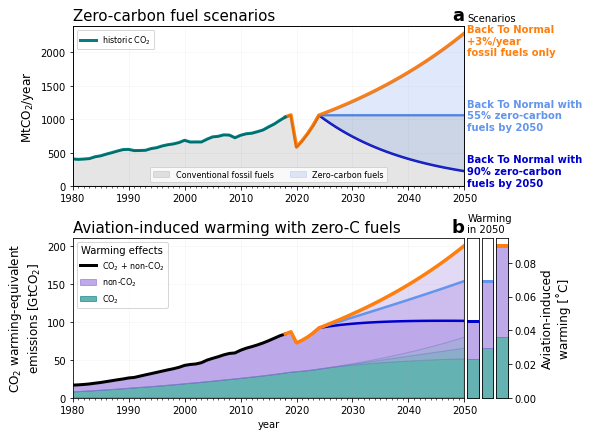

In [49]:
fig = plt.figure(figsize=(8,6))

ax1 = fig.add_axes([0.11,0.57,0.68,0.37])
ax3 = fig.add_axes([0.11,0.08,0.68,0.37])
ax2 = ax1.twinx()

# scenario axes
pos = ax3.get_position()
ax_s1 = fig.add_axes([pos.x1+0.005,pos.y0,0.02,pos.y1-pos.y0])
ax_s2 = fig.add_axes([pos.x1+0.03,pos.y0,0.02,pos.y1-pos.y0])
ax_s3 = fig.add_axes([pos.x1+0.055,pos.y0,0.02,pos.y1-pos.y0])
ax_s3.yaxis.set_label_position("right")
ax_s3.yaxis.tick_right()

# future scenarios
from2018 = 2018-1940
from2024 = 2024-1940
ax2.fill_between(years1940,co2_scenario5,alpha=0.1,color="k",label="Conventional fossil fuels")
ax2.fill_between(years1940[from2024:],co2_scenario3[from2024:],co2_scenario6[from2024:],alpha=0.2,color="cornflowerblue",label="Zero-carbon fuels")

ax1.plot(years1940[from2024-1:],co2_scenario6[from2024-1:],"mediumblue",lw=2.5)
ax1.plot(years1940[from2024-1:],co2_scenario5[from2024-1:],"cornflowerblue",lw=2.5)
ax1.plot(years1940[from2018:],co2_scenario3[from2018:],"C1",lw=3.5)

# historic
ax1.plot(years,co2,"teal",lw=3,label=r"historic CO$_2$")

ax1.set_title(r"Zero-carbon fuel scenarios",loc="left",fontsize=15)
ax1.set_title("a",loc="right",fontweight="bold",fontsize=18)
ax3.set_title("b",loc="right",fontweight="bold",fontsize=18)

ax1.set_ylabel(r"MtCO$_2$/year",fontsize=12)
ax1.set_xlim(1980,2050)
ax2.set_xlim(1980,2050)
ax3.set_xlim(1980,2050)
ax1.set_ylim(0,ax1.get_ylim()[1])
ax2.set_ylim(0,ax1.get_ylim()[1])
ax1.set_xticks(np.hstack((years,years_future)),minor=True)
ax3.set_xticks(np.hstack((years,years_future)),minor=True)
ax2.set_yticks([])

# WARMING-EQUIVALENT EMISSIONS AND WARMING
# historic
alfa=0.6
h3 = lambda y: 1-np.cbrt(1-y)

# cumulative
ax3.plot(years1940[:till2018],warming_scenario3[:till2018]/TCRE,"k",lw=3,label=r"CO$_2$ + non-CO$_2$")

# cumulative future
# CO2
ax3.fill_between(years1940,co2warm_scenario6/TCRE,
                 alpha=h3(alfa),color="teal")
ax3.fill_between(years1940,co2warm_scenario5/TCRE,
                 alpha=h3(alfa),color="teal")
ax3.fill_between(years1940,co2warm_scenario3/TCRE,
                 alpha=h3(alfa),color="teal")

# NON-CO2
ax3.plot(years1940[from2018:],warming_scenario3[from2018:]/TCRE,
         "C1",lw=3.5,zorder=10)
ax3.plot(years1940[from2024-1:],warming_scenario5[from2024-1:]/TCRE,
         "cornflowerblue",lw=2.5,zorder=9)
ax3.plot(years1940[from2024-1:],warming_scenario6[from2024-1:]/TCRE,
         "mediumblue",lw=2.5,zorder=8)

ax3.fill_between(years1940,warming_scenario5/TCRE,co2warm_scenario5/TCRE,
                 alpha=h3(alfa),color="mediumpurple")
ax3.fill_between(years1940,warming_scenario6/TCRE,co2warm_scenario6/TCRE,
                 alpha=h3(alfa),color="mediumpurple")
ax3.fill_between(years1940,warming_scenario3/TCRE,co2warm_scenario3/TCRE,
                 alpha=h3(alfa),color="mediumpurple")

# for legend only
ax3.fill_between([0,1],[0,1],color="mediumpurple",alpha=alfa,label="non-CO$_2$")
ax3.fill_between([0,1],[0,1],color="teal",alpha=alfa,label=r"CO$_2$")


# SCENARIO COMPARISON 2050
ax_s1.axhline(warming_scenario6[-1],color="mediumblue",lw=3)
ax_s2.axhline(warming_scenario5[-1],color="cornflowerblue",lw=3)
ax_s3.axhline(warming_scenario3[-1],color="C1",lw=4)

ax_s1.fill_between([0,1],np.ones(2)*co2warm_scenario6[-1],color="teal",alpha=alfa)
ax_s2.fill_between([0,1],np.ones(2)*co2warm_scenario5[-1],color="teal",alpha=alfa)
ax_s3.fill_between([0,1],np.ones(2)*co2warm_scenario3[-1],color="teal",alpha=alfa)

ax_s1.fill_between([0,1],np.ones(2)*warming_scenario6[-1],np.ones(2)*co2warm_scenario6[-1],color="mediumpurple",alpha=alfa)
ax_s2.fill_between([0,1],np.ones(2)*warming_scenario5[-1],np.ones(2)*co2warm_scenario5[-1],color="mediumpurple",alpha=alfa)
ax_s3.fill_between([0,1],np.ones(2)*warming_scenario3[-1],np.ones(2)*co2warm_scenario3[-1],color="mediumpurple",alpha=alfa)

ax3.set_title(r"Aviation-induced warming with zero-C fuels",loc="left",fontsize=15)
ax3.set_ylabel(r"CO$_2$ warming-equivalent"+"\n"+"emissions [GtCO$_2$]",fontsize=12)
ax_s3.set_ylabel("Aviation-induced\nwarming [˚C]",fontsize=12)
ax3.set_xlabel("year",fontsize=10)
ax1.legend(loc=2,fontsize=8)
ax2.legend(loc=8,fontsize=8,ncol=2)
ax3.legend(loc=2,title="Warming effects",fontsize=8)

ax3.set_ylim(0,ax3.get_ylim()[1])
for ax in [ax_s1,ax_s2,ax_s3]:
    ax.set_ylim(0,TCRE*ax3.get_ylim()[1])
    ax.set_xlim(0,1)

for ax in [ax_s1,ax_s2]:
    ax.set_yticks([])
    ax.set_xticks([])

ax_s3.set_xticks([])

ax1.grid(alpha=0.1)
ax3.grid(alpha=0.1)

ax1.text(2050.5,ax1.get_ylim()[1]*1.03,"Scenarios")
ax3.text(2050.5,ax3.get_ylim()[1]*1.035,"Warming\nin 2050")
ax1.text(2050.5,co2_scenario3[-1]*0.95,"Back To Normal\n+3%/year\nfossil fuels only",color="C1",fontweight="bold",va="center")
ax1.text(2050.5,co2_scenario5[-1],
         "Back To Normal with \n"+str(int(np.round((1-m5[-1])*20)*5))+"% zero-carbon\nfuels by 2050",color="cornflowerblue",fontweight="bold",va="center")
ax1.text(2050.5,co2_scenario6[-1],
         "Back To Normal with \n"+str(int(np.round((1-m6[-1])*20)*5))+"% zero-carbon\nfuels by 2050",color="mediumblue",fontweight="bold",va="center");

# plt.savefig("../plots/zeroc_fuels_warming.pdf")
# plt.savefig("../plots/zeroc_fuels_warming.png",dpi=200)

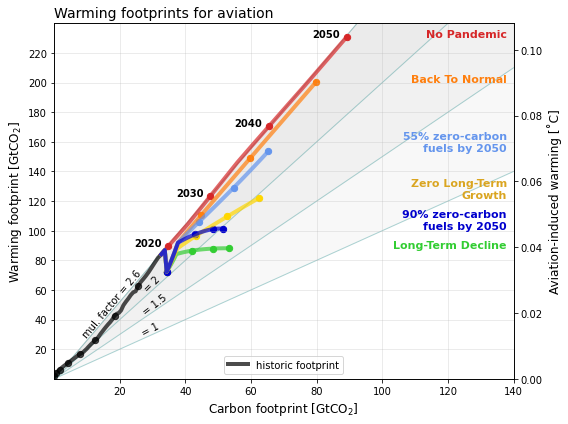

In [50]:
fig,ax = plt.subplots(1,1,figsize=(8,6))

ax2 = ax.twinx()
ax.set_xlim(0,140)
ax.set_ylim(0,240)
ax2.set_ylim(0,ax.get_ylim()[1]*TCRE)

lww = 4
alfa = 0.7
ax.plot(np.cumsum(co2_scenario1[:till2018])/1000,
        warming_scenario1[:till2018]/TCRE,"k",lw=lww,alpha=alfa,label="historic footprint")
ax.scatter(np.cumsum(co2_scenario1[:till2018])[0::10]/1000,
        warming_scenario1[:till2018][0::10]/TCRE,40,c="k",alpha=alfa)
ax.plot(np.cumsum(co2_scenario1)[from2018:]/1000,
        warming_scenario1[from2018:]/TCRE,c="limegreen",lw=lww,alpha=alfa)
ax.plot(np.cumsum(co2_scenario2)[from2018:]/1000,
        warming_scenario2[from2018:]/TCRE,c="gold",lw=lww,alpha=alfa)
ax.plot(np.cumsum(co2_scenario3)[from2018:]/1000,
        warming_scenario3[from2018:]/TCRE,c="C1",lw=lww,alpha=alfa)
ax.plot(np.cumsum(co2_scenario4)[from2018:]/1000,
        warming_scenario4[from2018:]/TCRE,c="C3",lw=lww,alpha=alfa)
ax.plot(np.cumsum(co2_scenario5)[from2018:]/1000,
        warming_scenario5[from2018:]/TCRE,c="cornflowerblue",lw=lww,alpha=alfa)
ax.plot(np.cumsum(co2_scenario6)[from2018:]/1000,
        warming_scenario6[from2018:]/TCRE,c="mediumblue",lw=lww,alpha=alfa)

cols = ["limegreen","gold","C1","C3","cornflowerblue","mediumblue"]
cols2 = ["limegreen","goldenrod","C1","C3","cornflowerblue","mediumblue"]
mark = ["o","o","o","o"]
labls = ["Long-Term Decline","Zero Long-Term\nGrowth","Back To Normal",
         "No Pandemic","55% zero-carbon\nfuels by 2050","90% zero-carbon\nfuels by 2050"]

for i,(c,w) in enumerate(zip([co2_scenario1,co2_scenario2,co2_scenario3,co2_scenario4,co2_scenario5,co2_scenario6],
                    [warming_scenario1,warming_scenario2,warming_scenario3,warming_scenario4,warming_scenario5,warming_scenario6])):
    for j,year in enumerate([2020,2030,2040,2050]):
        ax.scatter(np.cumsum(c)[year-1940]/1000,w[year-1940]/TCRE,40,c=cols[i],marker=mark[j])
        if i == 3:
            ax.text(-2+np.cumsum(c)[year-1940]/1000,w[year-1940]/TCRE,str(year),ha="right",fontweight="bold")
        if year == 2050:
            ax.text(ax.get_xlim()[1]-2,w[-1]/TCRE,labls[i],ha="right",c=cols2[i],fontweight="bold",size=11)

            
mulfac1 = 2.6
mulfac2 = 2
mulfac3 = 1.5
mulfac4 = 1
x1 = ax.get_xlim()[1]
ax.plot([0,x1],[0,x1*mulfac1],alpha=0.3,lw=1,ls="-",c="teal",zorder=-1)
ax.plot([0,x1],[0,x1*mulfac2],alpha=0.3,lw=1,ls="-",c="teal",zorder=-1)
ax.plot([0,x1],[0,x1*mulfac3],alpha=0.3,lw=1,ls="-",c="teal",zorder=-1)
ax.plot([0,x1],[0,x1*mulfac4],alpha=0.3,lw=1,ls="-",c="teal",zorder=-1)

ax.fill_between([0,x1],[0,x1*mulfac1],[0,x1*mulfac4],alpha=0.05,color="grey",zorder=-2)
ax.fill_between([0,x1],[0,x1*mulfac1],[0,x1*mulfac3],alpha=0.05,color="grey",zorder=-2)
ax.fill_between([0,x1],[0,x1*mulfac1],[0,x1*mulfac2],alpha=0.05,color="grey",zorder=-2)
ax.fill_between([0,x1],[0,x1*mulfac1],[0,x1*mulfac1],alpha=0.05,color="grey",zorder=-2)

xl,xl2 = 27,35
ax.text(xl,5+xl*mulfac1,"mul. factor = 2.6",rotation=50,ha="right",va="top")
ax.text(xl2,5+xl2*mulfac2,"= 2   ",rotation=45,ha="right",va="top")
ax.text(xl2,6+xl2*mulfac3,"= 1.5",rotation=38,ha="right",va="top")
ax.text(xl2,7+xl2*mulfac4,"= 1   ",rotation=28,ha="right",va="top")

ax.legend(loc=8)

ax.set_xlabel(r"Carbon footprint [GtCO$_2$]",fontsize=12)
ax.set_ylabel(r"Warming footprint [GtCO$_2$]",fontsize=12)
ax2.set_ylabel(r"Aviation-induced warming [˚C]",fontsize=12)
ax.grid(alpha=0.3)
ax.set_xticks(np.arange(20,160,20))
ax.set_yticks(np.arange(20,240,20))

ax.set_title("Warming footprints for aviation",loc="left",fontsize=14)
plt.tight_layout()
# plt.savefig("../plots/warming_footprints.pdf")
# plt.savefig("../plots/warming_footprints.png",dpi=200)

# CAEP trends

In [51]:
caep11 = pd.read_csv(path+"data/CAEP11_trends.csv")

In [52]:
caep_years = np.array(caep11.iloc[4:,0])
caep_sc1 = np.array(caep11.iloc[4:,ABC2index("H")],dtype=float)
caep_sc2 = np.array(caep11.iloc[4:,ABC2index("I")],dtype=float)
caep_sc3 = np.array(caep11.iloc[4:,ABC2index("J")],dtype=float)
caep_sc4 = np.array(caep11.iloc[4:,ABC2index("K")],dtype=float)
caep_sc5 = np.array(caep11.iloc[4:,ABC2index("L")],dtype=float)

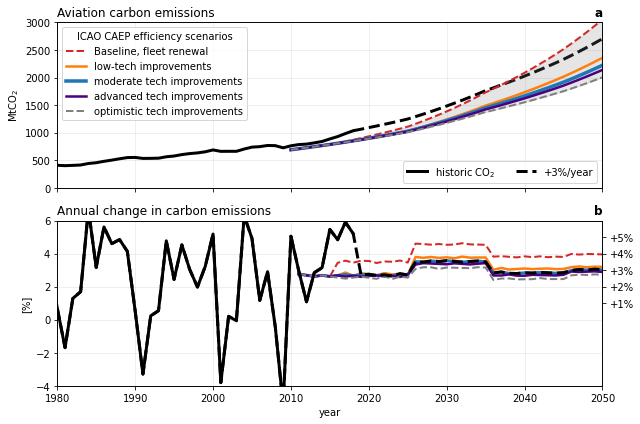

In [53]:
fig,(ax1,ax2) = plt.subplots(2,1,figsize=(9,6),sharex=True)

# historic
ax1.plot(years_1940,co2_1940,"k",lw=3,label=r"historic CO$_2$")
ax1.plot(years1940[from2018:],co2_scenario4[from2018:],"k--",lw=3,label="+3%/year")

ax1t = ax1.twinx()
ax2t = ax2.twinx()

# CAEP11 scenarios
offset = 0
ax1t.plot(caep_years,offset+caep_sc1,"C3",ls="--",lw=2,label="Baseline, fleet renewal")
ax1t.plot(caep_years,offset+caep_sc2,"C1",lw=2.5,label="low-tech improvements")
ax1t.plot(caep_years,offset+caep_sc3,"C0",lw=3.5,label="moderate tech improvements")
ax1t.plot(caep_years,offset+caep_sc4,"indigo",lw=2.5,label="advanced tech improvements")
ax1t.plot(caep_years,offset+caep_sc5,color="0.5",lw=2,ls="--",label="optimistic tech improvements")
ax1t.fill_between(caep_years,offset+caep_sc1,offset+caep_sc5,color="grey",alpha=.2)

# annual change
ax2.plot(caep_years[1:],100*np.diff(caep_sc1)/caep_sc1[:-1],"C3--",lw=2)
ax2.plot(caep_years[1:],100*np.diff(caep_sc2)/caep_sc2[:-1],"C1",lw=2.5)
ax2.plot(caep_years[1:],100*np.diff(caep_sc3)/caep_sc3[:-1],"C0",lw=3)
ax2.plot(caep_years[1:],100*np.diff(caep_sc4)/caep_sc4[:-1],c="indigo",lw=2.5)
ax2.plot(caep_years[1:],100*np.diff(caep_sc5)/caep_sc5[:-1],c="0.5",ls="--",lw=2)

ax2.plot(years_1940[1:],100*np.diff(co2_1940)/co2_1940[:-1],"k",lw=3)
ax2.plot(years1940[1:],100*np.diff(co2_scenario4)/co2_scenario4[:-1],"k--",lw=3)

ax1.legend(loc=4,ncol=2)
ax1t.legend(loc=2,title="ICAO CAEP efficiency scenarios")
ax1.set_xlim(1980,2050)
ax1.set_ylim(0,3000)
ax1t.set_ylim(ax1.get_ylim())
ax1t.set_yticks([])
ax2.set_ylim(-4,6)
ax2t.set_ylim(ax2.get_ylim())
ax2t.set_yticks([1,2,3,4,5])
ax2t.set_yticklabels(["+1%","+2%","+3%","+4%","+5%"])

ax1.grid(alpha=.25)
ax2.grid(alpha=.25)

ax1.set_ylabel("MtCO$_2$")
ax2.set_ylabel("[%]")
ax1.set_title("Aviation carbon emissions",loc="left")
ax2.set_title("Annual change in carbon emissions",loc="left")
ax1.set_title("a",loc="right",fontweight="bold")
ax2.set_title("b",loc="right",fontweight="bold")
ax2.set_xlabel("year")

plt.tight_layout()
# plt.savefig("../plots/caep_scenarios.pdf")
# plt.savefig("../plots/caep_scnearios.png",dpi=200)

# Warming stripes

In [54]:
import cmocean.cm as cmo
from matplotlib.colors import ListedColormap
from matplotlib.patches import Rectangle
from matplotlib.collections import PatchCollection

In [55]:
df = pd.read_fwf(
    '../data/HadCRUT.4.6.0.0.annual_ns_avg.txt',
    index_col=0,
    usecols=(0, 1),
    names=['year', 'anomaly'],
    header=None,
)

FIRST = 1980
LAST = 2021  # inclusive

# Reference period for the center of the color scale
FIRST_REFERENCE = 1850
LAST_REFERENCE = 1880
LIM = 0.5 # degrees

anomaly = df.loc[FIRST:LAST, 'anomaly'].dropna()
reference = df.loc[FIRST_REFERENCE:LAST_REFERENCE, 'anomaly'].mean()
anomaly_ref = np.array(anomaly)-reference


In [56]:
anomaly_ref

array([0.39396774, 0.44196774, 0.31296774, 0.49596774, 0.28796774,
       0.27196774, 0.34696774, 0.49396774, 0.49996774, 0.41996774,
       0.59796774, 0.55596774, 0.40696774, 0.44996774, 0.50996774,
       0.62696774, 0.48496774, 0.69196774, 0.84096774, 0.60796774,
       0.59596774, 0.74296774, 0.79796774, 0.80696774, 0.74896774,
       0.84696774, 0.80796774, 0.79296774, 0.69696774, 0.80796774,
       0.86196774, 0.72696774, 0.77196774, 0.81596774, 0.88096774,
       1.06496774, 1.09896774, 0.97896774, 0.89896774, 1.03796774,
       1.06996774, 0.92596774])

In [57]:
warming_stripes = ListedColormap([
    '#08306b', '#08519c', '#2171b5', '#4292c6',
    '#6baed6', '#9ecae1', '#c6dbef', '#deebf7',
    '#fee0d2', '#fcbba1', '#fc9272', '#fb6a4a',
    '#ef3b2c', '#cb181d', '#a50f15', '#67000d',
])

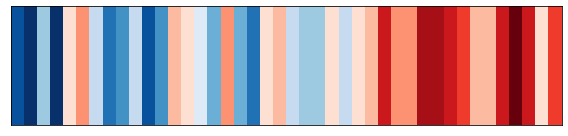

In [59]:
col = PatchCollection([
    Rectangle((y, 0), 1, 1)
    for y in range(FIRST, LAST + 1)
])

# set data, colormap and color limits
fig,ax = plt.subplots(1,1,figsize=(8,2))

perc_contribution = warming_scenario3[40:-29]/anomaly_ref*100

col.set_array(perc_contribution)
col.set_cmap(warming_stripes)
col.set_clim(min(perc_contribution), max(perc_contribution))
ax.add_collection(col)
ax.set_ylim(0, 1)
ax.set_xlim(FIRST, LAST + 1)
ax.set_xticks([])
ax.set_yticks([])
plt.tight_layout()
plt.savefig("warming_stripes.png",dpi=200)